# Data Analytics for Shoes products
## _**Making Product - Shoes Recommendations Using Neural Networks and Embeddings**_

--- 


# ** Amazon product dataset data analysis 

We can see this dataset includes information like:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case this products).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

For this example, let's limit ourselves to `customer_id`, `product_id`, and `star_rating`.  Including additional features in our recommendation system could be beneficial, but would require substantial processing (particularly the text data) which would take us beyond the scope of this notebook.

*Note: we'll keep `product_title` on the dataset to help verify our recommendations later in the notebook, but it will not be used in algorithm training.*

Because most people haven't seen most videos, and people rate fewer videos than we actually watch, we'd expect our data to be sparse.  Our algorithm should work well with this sparse problem in general, but we may still want to clean out some of the long tail.  Let's look at some basic percentiles to confirm.

In [1]:
!pip install ipython-autotime

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#### To measure all running time
# https://github.com/cpcloud/ipython-autotime

%load_ext autotime

In [3]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.mxnet import MXNet
import boto3
import json
import matplotlib.pyplot as plt

time: 2.15 s


In [4]:
# for basic visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# for advanced visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

time: 349 ms


---
## Data - https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt

### Explore

Let's start by bringing in our dataset from an S3 public bucket.  As mentioned above, this contains 1 to 5 star ratings from over 2M Amazon customers on over 160K digital videos.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

_Note, because this dataset is over a half gigabyte, the load from S3 may take ~10 minutes.  Also, since Amazon SageMaker Notebooks start with a 5GB persistent volume by default, and we don't need to keep this data on our instance for long, we'll bring it to the temporary volume (which has up to 20GB of storage)._

In [5]:
!aws s3 ls s3://amazon-reviews-pds/tsv/

2017-11-24 13:22:50          0 
2017-11-24 13:48:03  241896005 amazon_reviews_multilingual_DE_v1_00.tsv.gz
2017-11-24 13:48:17   70583516 amazon_reviews_multilingual_FR_v1_00.tsv.gz
2017-11-24 13:48:34   94688992 amazon_reviews_multilingual_JP_v1_00.tsv.gz
2017-11-24 13:49:14  349370868 amazon_reviews_multilingual_UK_v1_00.tsv.gz
2017-11-24 13:48:47 1466965039 amazon_reviews_multilingual_US_v1_00.tsv.gz
2017-11-24 13:49:53  648641286 amazon_reviews_us_Apparel_v1_00.tsv.gz
2017-11-24 13:56:36  582145299 amazon_reviews_us_Automotive_v1_00.tsv.gz
2017-11-24 14:04:02  357392893 amazon_reviews_us_Baby_v1_00.tsv.gz
2017-11-24 14:08:11  914070021 amazon_reviews_us_Beauty_v1_00.tsv.gz
2017-11-24 14:17:41 2740337188 amazon_reviews_us_Books_v1_00.tsv.gz
2017-11-24 14:45:50 2692708591 amazon_reviews_us_Books_v1_01.tsv.gz
2017-11-24 15:10:21 1329539135 amazon_reviews_us_Books_v1_02.tsv.gz
2017-11-24 15:22:13  442653086 amazon_reviews_us_Camera_v1_00.tsv.gz
2017-11-24 15:27:13 2689739299 amazon_rev

Let's read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

*Note, we'll set `error_bad_lines=False` when reading the file in as there appear to be a very small number of records which would create a problem otherwise.*

In [6]:
!rm -rf  /tmp/recsys/
!mkdir /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Shoes_v1_00.tsv.gz /tmp/recsys/

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Shoes_v1_00.tsv.gz to ../../../../../../tmp/recsys/amazon_reviews_us_Shoes_v1_00.tsv.gz
time: 4.71 s


Let's read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

*Note, we'll set `error_bad_lines=False` when reading the file in as there appear to be a very small number of records which would create a problem otherwise.*

In [7]:
!ls -alh /tmp/recsys/

total 613M
drwxrwxr-x  2 ec2-user ec2-user 4.0K May 16 17:04 .
drwxrwxrwx 15 root     root     148K May 16 17:03 ..
-rw-rw-r--  1 ec2-user ec2-user 613M Nov 25  2017 amazon_reviews_us_Shoes_v1_00.tsv.gz
time: 123 ms


In [8]:
df = pd.read_csv('/tmp/recsys/amazon_reviews_us_Shoes_v1_00.tsv.gz', delimiter='\t', error_bad_lines=False)

b'Skipping line 54101: expected 15 fields, saw 22\nSkipping line 55857: expected 15 fields, saw 22\nSkipping line 60448: expected 15 fields, saw 22\n'
b'Skipping line 76918: expected 15 fields, saw 22\nSkipping line 87925: expected 15 fields, saw 22\nSkipping line 88500: expected 15 fields, saw 22\nSkipping line 114276: expected 15 fields, saw 22\nSkipping line 128751: expected 15 fields, saw 22\n'
b'Skipping line 136095: expected 15 fields, saw 22\nSkipping line 140007: expected 15 fields, saw 22\nSkipping line 177148: expected 15 fields, saw 22\nSkipping line 180087: expected 15 fields, saw 22\nSkipping line 183010: expected 15 fields, saw 22\nSkipping line 183949: expected 15 fields, saw 22\nSkipping line 192879: expected 15 fields, saw 22\n'
b'Skipping line 223261: expected 15 fields, saw 22\nSkipping line 240588: expected 15 fields, saw 22\nSkipping line 247955: expected 15 fields, saw 22\nSkipping line 249336: expected 15 fields, saw 22\nSkipping line 259363: expected 15 fields, 

time: 40 s


In [9]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18069663,R3P2HIOQCIN5ZU,B000XB31C0,265024781,Minnetonka Men's Double Deerskin Softsole Mocc...,Shoes,1,0,0,N,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,US,16251825,R12VVR0WH5Q24V,B00CFYZH5W,259035853,Teva Men's Pajaro Flip-Flop,Shoes,5,0,0,N,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,US,20381037,RNCCKB6TV5EEF,B00S8JNN3Q,666066660,Anne Klein Perfect Pair Wristlet,Shoes,4,0,0,N,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31
3,US,108364,R2NZXYIVCGB13W,B00XFBPOQG,448483263,adidas Men's 10K Lifestyle Runner Sneaker,Shoes,5,0,6,N,Y,Badass,Getting what u see,2015-08-31
4,US,45449350,R2EQ1TG9IT3OEQ,B00SW64Y9W,7853171,OverBling Sneakers for Men Casual Men Shoes Ge...,Shoes,3,0,0,N,Y,Three Stars,small,2015-08-31


time: 22.7 ms


In [10]:
# shape of data
df.shape

(4358820, 15)

time: 2.77 ms


In [11]:
# Describing the data set
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,4.358820e+06,4.358820e+06,4.358820e+06,4.358820e+06,4.358820e+06
mean,2.631178e+07,4.983149e+08,4.241249e+00,8.777460e-01,1.076503e+00
std,1.546916e+07,2.898457e+08,1.157505e+00,7.563358e+00,8.137539e+00
min,1.001700e+04,2.220000e+02,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.338500e+07,2.463836e+08,4.000000e+00,0.000000e+00,0.000000e+00
50%,2.445766e+07,4.976083e+08,5.000000e+00,0.000000e+00,0.000000e+00
75%,4.090312e+07,7.502587e+08,5.000000e+00,1.000000e+00,1.000000e+00
max,5.309657e+07,9.999999e+08,5.000000e+00,5.070000e+03,5.329000e+03


time: 1.28 s


In [12]:
# checking if there is any null data or not
df.isnull().sum()

marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          1
product_category       0
star_rating            0
helpful_votes          0
total_votes            0
vine                   0
verified_purchase      0
review_headline       26
review_body          440
review_date           21
dtype: int64

time: 3.1 s


In [13]:
# remove numm data
df = df.dropna()

time: 4.15 s


In [14]:
df.head(n=3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18069663,R3P2HIOQCIN5ZU,B000XB31C0,265024781,Minnetonka Men's Double Deerskin Softsole Mocc...,Shoes,1,0,0,N,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,US,16251825,R12VVR0WH5Q24V,B00CFYZH5W,259035853,Teva Men's Pajaro Flip-Flop,Shoes,5,0,0,N,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,US,20381037,RNCCKB6TV5EEF,B00S8JNN3Q,666066660,Anne Klein Perfect Pair Wristlet,Shoes,4,0,0,N,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31


time: 14.9 ms


In [15]:
# checking if there is any null data or not
df.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

time: 3.1 s


In [16]:
# Describing the data according to the ratings
df.groupby('star_rating').describe()

customer_id                                                    \
                  count          mean           std      min          25%   
star_rating                                                                 
1              231702.0  2.613264e+07  1.555256e+07  10216.0  13159540.00   
2              242368.0  2.728759e+07  1.524881e+07  10121.0  14220759.25   
3              403414.0  2.675237e+07  1.538036e+07  10017.0  13773124.75   
4              846151.0  2.642434e+07  1.545640e+07  10053.0  13493269.00   
5             2634698.0  2.613613e+07  1.549374e+07  10022.0  13235135.50   

                                                 product_parent                \
                    50%          75%         max          count          mean   
star_rating                                                                     
1            24184169.5  40816197.00  53096405.0       231702.0  4.972857e+08   
2            25811489.5  41616422.25  53096567.0       242368.0  4.992033e+08   
3            25079965.5  41269264.50  53096471.0       403414.0  4.976268e+08   
4            24626637.0  41006751.50  53096474.0       846151.0  4.983365e+08   
5            24214413.0  40719567.00  53096567.0      2634698.0  4.984187e+08   

             ... helpful_votes         total_votes                            \
             ...           75%     max       count      mean        std  min   
star_rating  ...                                                               
1            ...           1.0  2293.0    231702.0  2.729437  12.343236  0.0   
2            ...           1.0   769.0    242368.0  1.558164   6.155664  0.0   
3            ...           1.0   494.0    403414.0  1.178992   5.193058  0.0   
4            ...           0.0  1338.0    846151.0  0.896550   4.915773  0.0   
5            ...           0.0  5070.0   2634698.0  0.927385   8.966711  0.0   

                                    
             25%  50%  75%     max  
star_rating                         
1            0.0  1.0  2.0  2522.0  
2            0.0  0.0  1.0   799.0  
3            0.0  0.0  1.0   513.0  
4            0.0  0.0  1.0  1357.0  
5            0.0  0.0  1.0  5329.0  

[5 rows x 32 columns]

time: 3.5 s


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4358333 entries, 0 to 4358819
Data columns (total 15 columns):
marketplace          object
customer_id          int64
review_id            object
product_id           object
product_parent       int64
product_title        object
product_category     object
star_rating          int64
helpful_votes        int64
total_votes          int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtypes: int64(5), object(10)
memory usage: 532.0+ MB
time: 5.15 ms


In [18]:
# #Five point summary 
df.describe()['star_rating'].T

count    4.358333e+06
mean     4.241249e+00
std      1.157492e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: star_rating, dtype: float64

time: 979 ms


## Data Visualizations

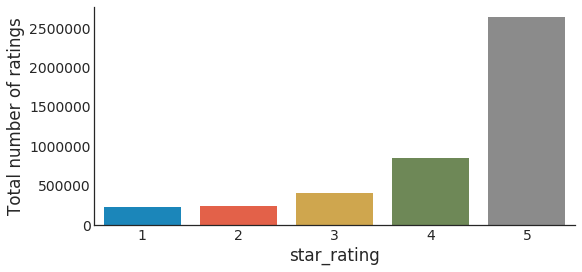

time: 4.43 s


In [20]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("star_rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [21]:
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

time: 3 ms


In [22]:
# Unique Users and products

print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.review_id)))
print("Total No of products  :", len(np.unique(df.product_id)))

Total data 
--------------------------------------------------

Total no of ratings : 4358333
Total No of Users   : 4358333
Total No of products  : 1898784
time: 17.9 s


In [28]:
# Analysis of rating given by the user 

no_of_rated_products_per_user = df.groupby(by='customer_id')['star_rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

customer_id
45547332    210
2761437     194
52433525    170
12228192    159
20872710    152
Name: star_rating, dtype: int64

time: 2.13 s


In [29]:
no_of_rated_products_per_user.describe()

count    2.812544e+06
mean     1.549605e+00
std      1.597413e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.100000e+02
Name: star_rating, dtype: float64

time: 104 ms


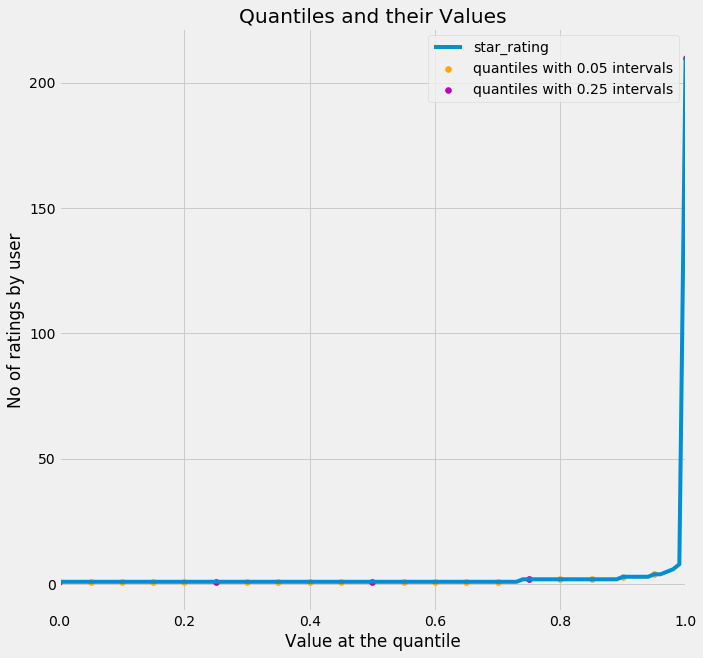

time: 425 ms


In [30]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [31]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 130

time: 265 ms


### Popularity Based Recommendation

- Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

- The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

In [32]:
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

time: 2.98 ms


In [33]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=df.groupby("product_id").filter(lambda x:x['star_rating'].count() >=50)

time: 12min 29s


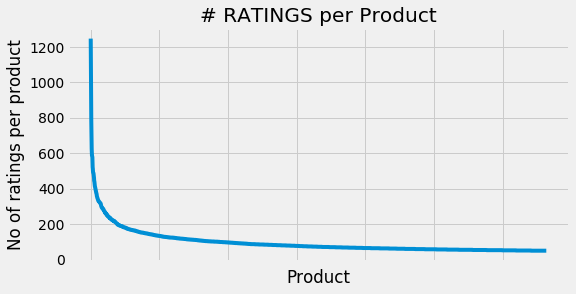

time: 293 ms


In [34]:
no_of_ratings_per_product = new_df.groupby(by='product_id')['star_rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [35]:
#Average rating of the product 

new_df.groupby('product_id')['star_rating'].mean().head()

product_id
B00006XXGO    4.016667
B000075FOD    4.764706
B00007GD8X    4.107143
B00007GDAL    3.972973
B0000AWJJN    3.745455
Name: star_rating, dtype: float64

time: 65 ms


In [36]:
new_df.groupby('product_id')['star_rating'].mean().sort_values(ascending=False).head()

product_id
B00KNZ15BA    4.967742
B003YVIAJK    4.960784
B0047ZG5QC    4.929825
B00MP0R3XK    4.915254
B000XPOUUI    4.913793
Name: star_rating, dtype: float64

time: 61.8 ms


In [37]:
#Total no of rating for product

new_df.groupby('product_id')['star_rating'].count().sort_values(ascending=False).head()

product_id
B00H9RZDRM    1247
B002L9AL84    1110
B004M6W4FW     891
B004RR0N8Q     801
B001UQ71G4     785
Name: star_rating, dtype: int64

time: 60.9 ms


In [38]:
ratings_mean_count = pd.DataFrame(new_df.groupby('product_id')['star_rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('product_id')['star_rating'].count())
ratings_mean_count.head()

,star_rating,rating_counts
product_id,,
B00006XXGO,4.016667,60
B000075FOD,4.764706,68
B00007GD8X,4.107143,84
B00007GDAL,3.972973,74
B0000AWJJN,3.745455,55


time: 128 ms


In [39]:
ratings_mean_count['rating_counts'].max()

1247

time: 2.87 ms


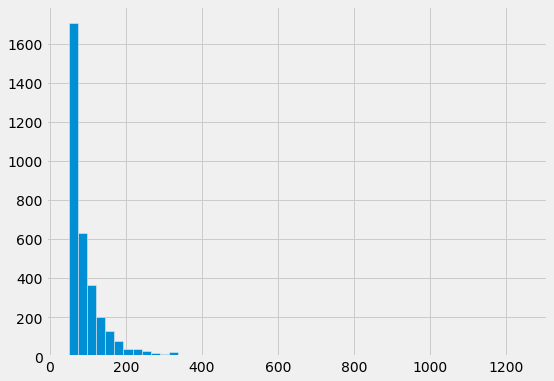

time: 393 ms


In [40]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

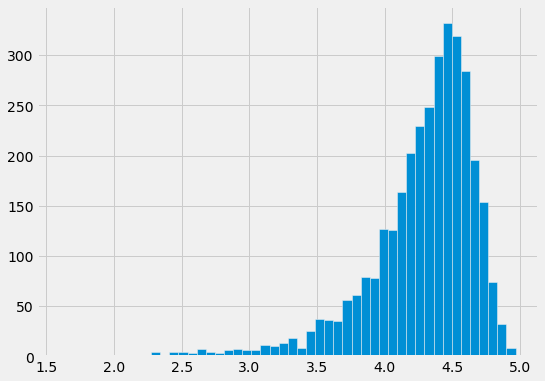

time: 348 ms


In [44]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['star_rating'].hist(bins=50)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



<Figure size 576x432 with 0 Axes>

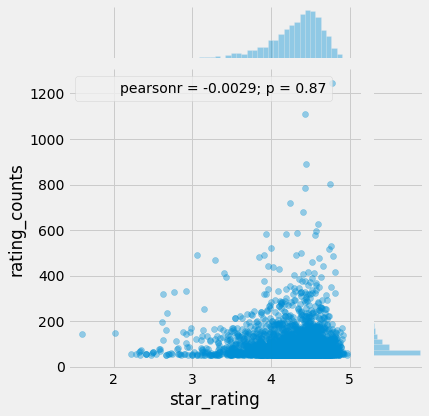

time: 798 ms


In [45]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='star_rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

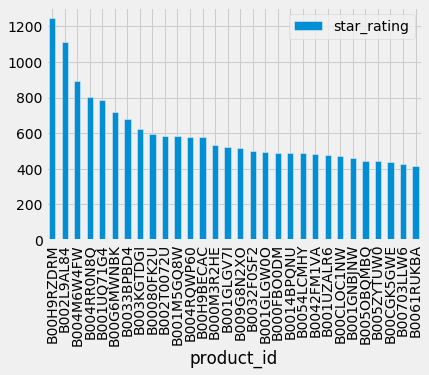

time: 511 ms


In [47]:
popular_products = pd.DataFrame(new_df.groupby('product_id')['star_rating'].count())
most_popular = popular_products.sort_values('star_rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# Wordcloud

In [48]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

time: 240 ms


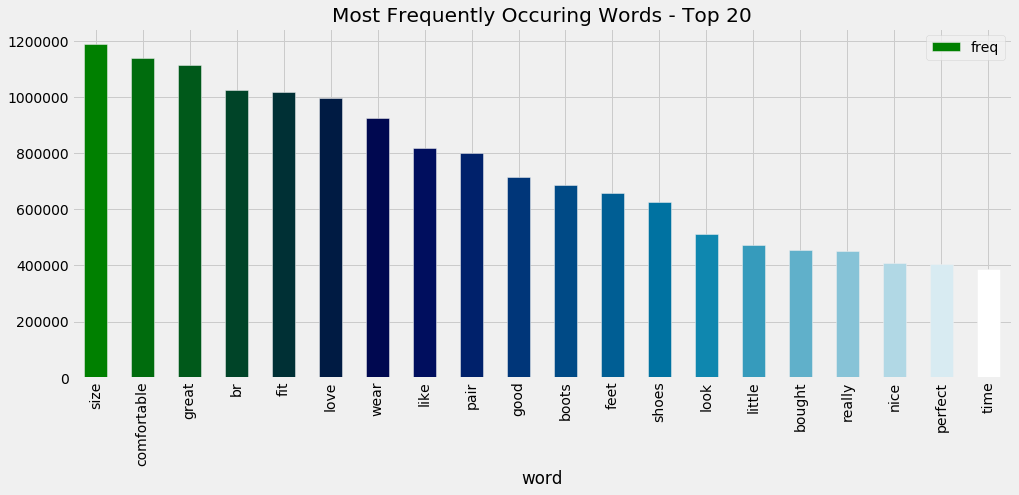

time: 8min 5s


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Import stopwords with nltk.
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

##Creating a list of custom stopwords
new_words = [
                "shoes", "shoe", "br"
            ]

# add stop word - keep adding based on needs.
stop_words.extend(new_words)

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df['review_body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])))
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20")
plt.show()

In [ ]:
# !pip install wordcloud

time: 600 µs


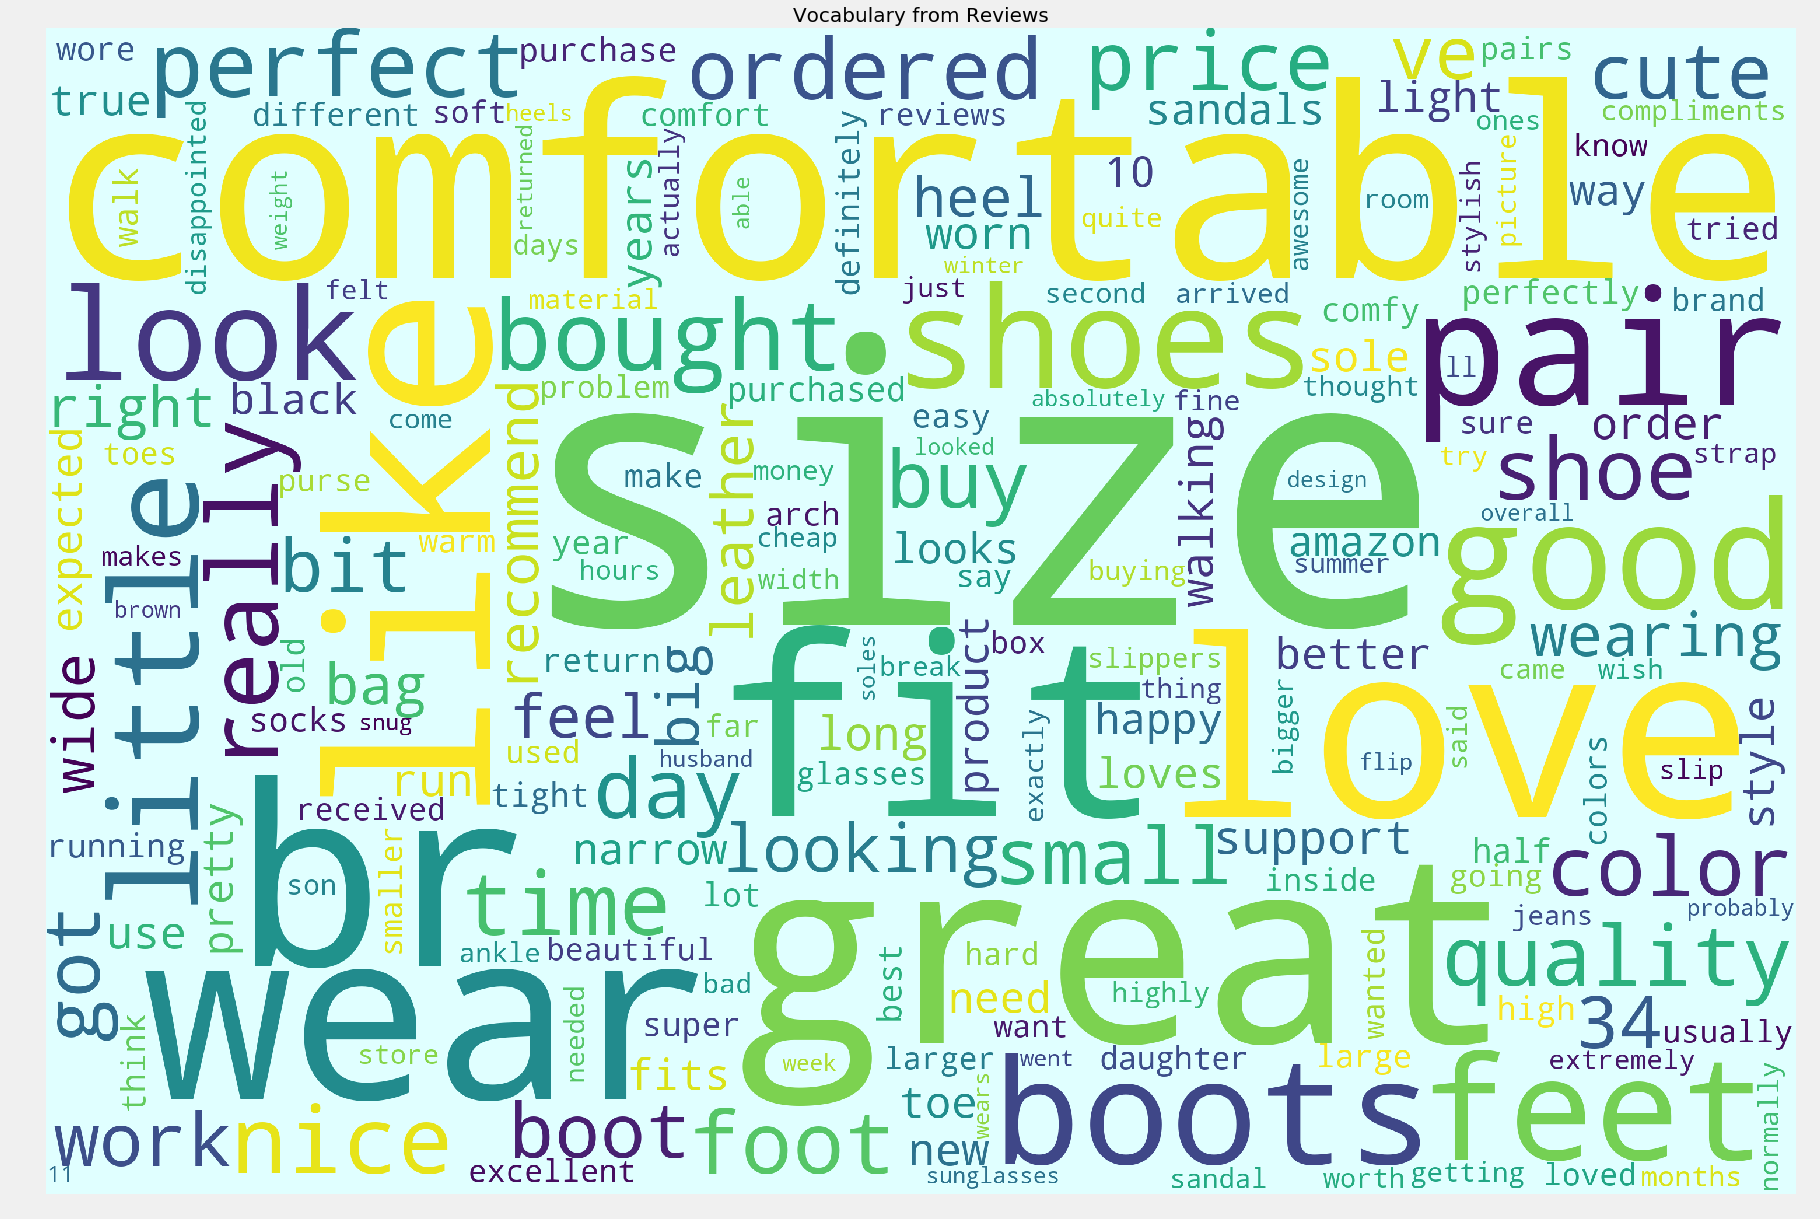

time: 17.8 s


In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'lightcyan', width = 3000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 20))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20)
plt.show()

In [ ]:
df.head(n=3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18069663,R3P2HIOQCIN5ZU,B000XB31C0,265024781,Minnetonka Men's Double Deerskin Softsole Mocc...,Shoes,1,0,0,N,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,US,16251825,R12VVR0WH5Q24V,B00CFYZH5W,259035853,Teva Men's Pajaro Flip-Flop,Shoes,5,0,0,N,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,US,20381037,RNCCKB6TV5EEF,B00S8JNN3Q,666066660,Anne Klein Perfect Pair Wristlet,Shoes,4,0,0,N,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31


time: 15.6 ms


In [ ]:
df = df[['customer_id', 'product_id', 'star_rating', 'product_title']]

In [ ]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('customers\n', customers.quantile(quantiles))
print('products\n', products.quantile(quantiles))

As we can see, only about 5% of customers have rated 5 or more videos, and only 25% of videos have been rated by 9+ customers.

### Clean

Let's filter out this long tail.

In [ ]:
customers = customers[customers >= 5]
products = products[products >= 10]

reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))

Now, we'll recreate our customer and product lists since there are customers with more than 5 reviews, but all of their reviews are on products with less than 5 reviews (and vice versa).

In [ ]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

Next, we'll number each user and item, giving them their own sequential index.  This will allow us to hold the information in a sparse format where the sequential indices indicate the row and column in our ratings matrix.

In [ ]:
customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0])})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

### Prepare

Let's start by splitting in training and test sets.  This will allow us to estimate the model's accuracy on videos our customers rated, but wasn't included in our training.

In [ ]:
test_df = reduced_df.groupby('customer_id').last().reset_index()

train_df = reduced_df.merge(test_df[['customer_id', 'product_id']], 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
train_df = train_df[(train_df['_merge'] == 'left_only')]

Now, we can convert our Pandas DataFrames into MXNet NDArrays, use those to create a member of the SparseMatrixDataset class, and add that to an MXNet Data Iterator.  This process is the same for both test and control.

In [ ]:
batch_size = 1024

train = gluon.data.ArrayDataset(nd.array(train_df['user'].values, dtype=np.float32),
                                nd.array(train_df['item'].values, dtype=np.float32),
                                nd.array(train_df['star_rating'].values, dtype=np.float32))
test  = gluon.data.ArrayDataset(nd.array(test_df['user'].values, dtype=np.float32),
                                nd.array(test_df['item'].values, dtype=np.float32),
                                nd.array(test_df['star_rating'].values, dtype=np.float32))

train_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')
test_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')

---

## Train Locally

### Define Network

Let's start by defining the neural network version of our matrix factorization task.  In this case, our network is quite simple.  The main components are:
- [Embeddings](https://mxnet.incubator.apache.org/api/python/gluon/nn.html#mxnet.gluon.nn.Embedding) which turn our indexes into dense vectors of fixed size.  In this case, 64.
- [Dense layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dense) with ReLU activation.  Each dense layer has the same number of units as our number of embeddings.  Our ReLU activation here also adds some non-linearity to our matrix factorization.
- [Dropout layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dropout) which can be used to prevent over-fitting.
- Matrix multiplication of our user matrix and our item matrix to create an estimate of our rating matrix.

In [ ]:
class MFBlock(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFBlock, self).__init__()
        
        self.max_users = max_users
        self.max_items = max_items
        self.dropout_p = dropout_p
        self.num_emb = num_emb
        
        with self.name_scope():
            self.user_embeddings = gluon.nn.Embedding(max_users, num_emb)
            self.item_embeddings = gluon.nn.Embedding(max_items, num_emb)
            
            self.dropout_user = gluon.nn.Dropout(dropout_p)
            self.dropout_item = gluon.nn.Dropout(dropout_p)

            self.dense_user   = gluon.nn.Dense(num_emb, activation='relu')
            self.dense_item = gluon.nn.Dense(num_emb, activation='relu')
            
    def hybrid_forward(self, F, users, items):
        a = self.user_embeddings(users)
        a = self.dense_user(a)
        
        b = self.item_embeddings(items)
        b = self.dense_item(b)

        predictions = self.dropout_user(a) * self.dropout_item(b)     
        predictions = F.sum(predictions, axis=1)
        return predictions

In [ ]:
num_embeddings = 64

net = MFBlock(max_users=customer_index.shape[0], 
              max_items=product_index.shape[0],
              num_emb=num_embeddings,
              dropout_p=0.5)


### Set Parameters

Let's initialize network weights and set our optimization parameters.

In [ ]:
# Initialize network parameters
ctx = mx.gpu()
net.collect_params().initialize(mx.init.Xavier(magnitude=60),
                                ctx=ctx,
                                force_reinit=True)
net.hybridize()

# Set optimization parameters
opt = 'sgd'
lr = 0.02
momentum = 0.9
wd = 0.

trainer = gluon.Trainer(net.collect_params(),
                        opt,
                        {'learning_rate': lr,
                         'wd': wd,
                         'momentum': momentum})

### Execute

Let's define a function to carry out the training of our neural network.

In [ ]:
def execute(train_iter, test_iter, net, epochs, ctx):
    
    loss_function = gluon.loss.L2Loss()
    for e in range(epochs):
        
        print("epoch: {}".format(e))
        
        for i, (user, item, label) in enumerate(train_iter):
                user = user.as_in_context(ctx)
                item = item.as_in_context(ctx)
                label = label.as_in_context(ctx)
                
                with mx.autograd.record():
                    output = net(user, item)               
                    loss = loss_function(output, label)
                    
                loss.backward()
                trainer.step(batch_size)

        print("EPOCH {}: MSE ON TRAINING and TEST: {}. {}".format(e,
                                                                   eval_net(train_iter, net, ctx, loss_function),
                                                                   eval_net(test_iter, net, ctx, loss_function)))
    print("end of training")
    return net

Let's also define a function which evaluates our network on a given dataset.  This is called by our `execute` function above to provide mean squared error values on our training and test datasets.

In [ ]:
def eval_net(data, net, ctx, loss_function):
    acc = MSE()
    for i, (user, item, label) in enumerate(data):
        
            user = user.as_in_context(ctx)
            item = item.as_in_context(ctx)
            label = label.as_in_context(ctx)
            predictions = net(user, item).reshape((batch_size, 1))
            acc.update(preds=[predictions], labels=[label])
   
    return acc.get()[1]

Now, let's train for a few epochs.

In [ ]:
%%time

epochs = 3

trained_net = execute(train_iter, test_iter, net, epochs, ctx)

#### Early Validation

We can see our training error going down, but our validation accuracy bounces around a bit.  Let's check how our model is predicting for an individual user.  We could pick randomly, but for this case, let's try user #6.

In [ ]:
product_index['u6_predictions'] = trained_net(nd.array([6] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u6_predictions', ascending=False)

Now let's compare this to the predictions for another user (we'll try user #7).

In [ ]:
product_index['u7_predictions'] = trained_net(nd.array([7] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u7_predictions', ascending=False)

The predicted ratings are different between the two users, but the same top (and bottom) items for user #6 appear for #7 as well.  Let's look at the correlation across the full set of 38K items to see if this relationship holds.

In [ ]:
product_index[['u6_predictions', 'u7_predictions']].plot.scatter('u6_predictions', 'u7_predictions')
plt.show()

We can see that this correlation is nearly perfect.  Essentially the average rating of items dominates across users and we'll recommend the same well-reviewed items to everyone.  As it turns out, we can add more embeddings and this relationship will go away since we're better able to capture differential preferences across users.

However, with just a 64 dimensional embedding, it took 7 minutes to run just 3 epochs.  If we ran this outside of our Notebook Instance we could run larger jobs and move on to other work would improve productivity.

---

## Train with SageMaker

Now that we've trained on this smaller dataset, we can expand training in SageMaker's distributed, managed training environment.

### Wrap Code

To use SageMaker's pre-built MXNet container, we'll need to wrap our code from above into a Python script.  There's a great deal of flexibility in using SageMaker's pre-built containers, and detailed documentation can be found [here](https://github.com/aws/sagemaker-python-sdk#mxnet-sagemaker-estimators), but for our example, it consisted of:
1. Wrapping all data preparation into a `prepare_train_data` function (we could name this whatever we like)
1. Copying and pasting classes and functions from above word-for-word
1. Defining a `train` function that:
  1. Adds a bit of new code to pick up the input TSV dataset on the SageMaker Training cluster
  1. Takes in a dict of hyperparameters (which we specified as globals above)
  1. Creates the net and executes training

In [ ]:
!cat recommender.py

### Test Locally

Now we can test our train function locally.  This helps ensure we don't have any bugs before submitting our code to SageMaker's pre-built MXNet container.

In [ ]:
!ls -al /tmp/recsys/

In [ ]:
%%time

import recommender

local_test_net, local_customer_index, local_product_index = recommender.train(
    {'train': '/tmp/recsys/'}, 
    {'num_embeddings': 64, 
     'opt': 'sgd', 
     'lr': 0.02, 
     'momentum': 0.9, 
     'wd': 0.,
     'epochs': 10},
    ['local'],
    1)

### Move Data

Holding our data in memory works fine when we're interactively exploring a sample of data, but for larger, longer running processes, we'd prefer to run them in the background with SageMaker Training.  To do this, let's move the dataset to S3 so that it can be picked up by SageMaker training.  This is perfect for use cases like periodic re-training, expanding to a larger dataset, or moving production workloads to larger hardware.

In [ ]:
# change log level
import logging

logger = logging.getLogger()
logger.addHandler(logging.StreamHandler()) # Writes to console
logger.setLevel(logging.DEBUG)
logging.getLogger('boto3').setLevel(logging.CRITICAL)
logging.getLogger('botocore').setLevel(logging.CRITICAL)
logging.getLogger('s3transfer').setLevel(logging.CRITICAL)
logging.getLogger('urllib3').setLevel(logging.CRITICAL)

In [ ]:
bucket

In [ ]:
prefix

In [ ]:
# amazon_reviews_us_Shoes_v1_00

boto3.client('s3').copy({'Bucket': 'amazon-reviews-pds', 
                         'Key': 'tsv/amazon_reviews_us_Shoes_v1_00.tsv.gz'},
                        bucket,
                        prefix + '/train/amazon_reviews_us_Shoes_v1_00.tsv.gz')

### Submit

Now, we can create an MXNet estimator from the SageMaker Python SDK.  To do so, we need to pass in:
1. Instance type and count for our SageMaker Training cluster.  SageMaker's MXNet containers support distributed GPU training, so we could easily set this to multiple ml.p2 or ml.p3 instances if we wanted.
  - *Note, this would require some changes to our recommender.py script as we would need to setup the context an key value store properly, as well as determining if and how to distribute the training data.*
1. An S3 path for out model artifacts and a role with access to S3 input and output paths.
1. Hyperparameters for our neural network.  Since with a 64 dimensional embedding, our recommendations reverted too closely to the mean, let's increase this by an order of magnitude when we train outside of our local instance.  We'll also increase the epochs to see how our accuracy evolves over time. We'll leave all other hyperparameters the same.

Once we use `.fit()` this creates a SageMaker Training Job that spins up instances, loads the appropriate packages and data, runs our `train` function from `recommender.py`, wraps up and saves model artifacts to S3, and finishes by tearing down the cluster.

In [ ]:
print( 's3://{}/{}/train/'.format(bucket, prefix))

In [ ]:
!aws s3 ls s3://dse-cohort5-group1/sagemaker/amazon_reviews_us_Shoes_v1_00/train/

## Use ml.p3.8xlarge for training
```
2020-05-16 06:28:03 Completed - Training job completed
Training seconds: 203
Billable seconds: 203
```

In [ ]:
m = MXNet('recommender.py', 
          py_version='py3',
          role=role, 
          train_instance_count=1, 
          train_instance_type="ml.p3.8xlarge",
          output_path='s3://{}/{}/output'.format(bucket, prefix),
          hyperparameters={'num_embeddings': 512, 
                           'opt': opt, 
                           'lr': lr, 
                           'momentum': momentum, 
                           'wd': wd,
                           'epochs': 30},
         framework_version='1.1')

m.fit({'train': 's3://{}/{}/train/'.format(bucket, prefix)})

---

## Host

Now that we've trained our model, deploying it to a real-time, production endpoint is easy.

In [ ]:
predictor = m.deploy(initial_instance_count=1, 
                     instance_type='ml.m4.xlarge')
predictor.serializer = None

Now that we have an endpoint, let's test it out.  We'll predict user #6's ratings for the top and bottom ASINs from our local model.

*This could be done by sending HTTP POST requests from a separate web service, but to keep things easy, we'll just use the `.predict()` method from the SageMaker Python SDK.*

In [ ]:
predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist(), 
                              'product_id': ['B00HSJRT7I', 'B001FA1O1S']}))

*Note, some of our predictions are actually greater than 5, which is to be expected as we didn't do anything special to account for ratings being capped at that value.  Since we are only looking to ranking by predicted rating, this won't create problems for our specific use case.*

In [ ]:
json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist(), 'product_id': ['B00HSJRT7I', 'B001FA1O1S']})

In [ ]:
reduced_df.sample(n=2)

### Evaluate

Let's start by calculating a naive baseline to approximate how well our model is doing.  The simplest estimate would be to assume every user item rating is just the average rating over all ratings.

*Note, we could do better by using each individual video's average, however, in this case it doesn't really matter as the same conclusions would hold.*

In [ ]:
print('Naive MSE:', np.mean((test_df['star_rating'] - np.mean(train_df['star_rating'])) ** 2))

Now, we'll calculate predictions for our test dataset.

*Note, this will align closely to our CloudWatch output above, but may differ slightly due to skipping partial mini-batches in our eval_net function.*

In [ ]:
test_preds = []
for array in np.array_split(test_df[['customer_id', 'product_id']].values, 40):
    test_preds += predictor.predict(json.dumps({'customer_id': array[:, 0].tolist(), 
                                                'product_id': array[:, 1].tolist()}))

test_preds = np.array(test_preds)
print('MSE:', np.mean((test_df['star_rating'] - test_preds) ** 2))

We can see that our neural network and embedding model produces substantially better results (~1.27 vs 1.65 on mean square error).

For recommender systems, subjective accuracy also matters.  Let's get some recommendations for a random user to see if they make intuitive sense.

In [ ]:
reduced_df[reduced_df['user'] == 6].sort_values(['star_rating', 'item'], ascending=[False, True])

In [ ]:
reduced_df.to_csv("./amazon_reviews_us_Shoes_v1_00.csv")

As we can see, user #6 seems to like sprawling dramamtic television series and sci-fi, but they dislike silly comedies.

Now we'll loop through and predict user #6's ratings for every common video in the catalog, to see which ones we'd recommend and which ones we wouldn't.

In [ ]:
predictions = []
for array in np.array_split(product_index['product_id'].values, 40):
    predictions += predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist() * array.shape[0], 
                                                 'product_id': array.tolist()}))

predictions = pd.DataFrame({'product_id': product_index['product_id'],
                            'prediction': predictions})

In [ ]:
titles = reduced_df.groupby('product_id')['product_title'].last().reset_index()
predictions_titles = predictions.merge(titles)
predictions_titles.sort_values(['prediction', 'product_id'], ascending=[False, True])

Indeed, our predicted highly rated shows have some well-reviewed TV dramas and some sci-fi.  Meanwhile, our bottom rated shows include goofball comedies.

*Note, because of random initialization in the weights, results on subsequent runs may differ slightly.*

Let's confirm that we no longer have almost perfect correlation in recommendations with user #7.

In [ ]:
reduced_df.to_csv("./user_6_amazon_reviews_us_Shoes_v1_00.csv")

In [ ]:
predictions_user7 = []
for array in np.array_split(product_index['product_id'].values, 40):
    predictions_user7 += predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 7]['customer_id'].values.tolist() * array.shape[0], 
                                                       'product_id': array.tolist()}))
plt.scatter(predictions['prediction'], np.array(predictions_user7))
plt.show()

---

## Wrap-up

In this example, we developed a deep learning model to predict customer ratings.  This could serve as the foundation of a recommender system in a variety of use cases.  However, there are many ways in which it could be improved.  For example we did very little with:
- hyperparameter tuning
- controlling for overfitting (early stopping, dropout, etc.)
- testing whether binarizing our target variable would improve results
- including other information sources (video genres, historical ratings, time of review)
- adjusting our threshold for user and item inclusion 

In addition to improving the model, we could improve the engineering by:
- Setting the context and key value store up for distributed training
- Fine tuning our data ingestion (e.g. num_workers on our data iterators) to ensure we're fully utilizing our GPU
- Thinking about how pre-processing would need to change as datasets scale beyond a single machine

Beyond that, recommenders are a very active area of research and techniques from active learning, reinforcement learning, segmentation, ensembling, and more should be investigated to deliver well-rounded recommendations.

### Clean-up (optional)

Let's finish by deleting our endpoint to avoid stray hosting charges.

In [ ]:
# sagemaker.Session().delete_endpoint(predictor.endpoint)

# Reference

- t-SNE vs PCA
    - https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1
    - https://www.kaggle.com/premvardhan/amazon-fine-food-review-tsne-visualization